In [8]:
!cp /content/drive/"My Drive"/kaggle/moa/lish-moa.zip /content/

In [ ]:
!unzip lish-moa.zip

In [ ]:
!pip install pip install iterative-stratification

In [3]:
from sklearn.preprocessing import MinMaxScaler
        
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler


import numpy as np 
import pandas as pd 
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d   ## smoother
from tqdm.notebook import tqdm, tnrange
import random
import os

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

plt.rcParams['figure.figsize'] = 15, 7

CGREEN  = '\33[32m'
CBLUE =  '\033[34m'
CRED = '\033[1;31m'
CEND  = '\33[0m'

def seed_everything(seed=1903):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'
    
device


'cuda'

In [11]:
train_features = pd.read_csv('train_features.csv')
train_targets = pd.read_csv('train_targets_scored.csv')
test_features = pd.read_csv('test_features.csv')

In [12]:
def preprocess(df):
    df = df.copy()
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
    return df

train = preprocess(train_features)
test = preprocess(test_features)

del train_targets['sig_id']

target = train_targets.loc[train['cp_type']==0].reset_index(drop=True)
train = train.loc[train['cp_type']==0].reset_index(drop=True)

In [13]:
top_features = [  1,   2,   3,   4,   5,   6,   7,   9,  11,  14,  15,  16,  17,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  29,  30,  31,
        32,  33,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  46,
        47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  78,  79,  80,  81,  82,  83,  84,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
       184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197,
       198, 199, 200, 202, 203, 204, 205, 206, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 224, 225, 226,
       227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
       240, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253,
       254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266,
       267, 268, 269, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280,
       281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 294,
       295, 296, 298, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309,
       310, 311, 312, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323,
       324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336,
       337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349,
       350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362,
       363, 364, 365, 366, 367, 368, 369, 370, 371, 374, 375, 376, 377,
       378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 390, 391,
       392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404,
       405, 406, 407, 408, 409, 411, 412, 413, 414, 415, 416, 417, 418,
       419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
       432, 434, 435, 436, 437, 438, 439, 440, 442, 443, 444, 445, 446,
       447, 448, 449, 450, 453, 454, 456, 457, 458, 459, 460, 461, 462,
       463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475,
       476, 477, 478, 479, 481, 482, 483, 484, 485, 486, 487, 488, 489,
       490, 491, 492, 493, 494, 495, 496, 498, 500, 501, 502, 503, 505,
       506, 507, 509, 510, 511, 512, 513, 514, 515, 518, 519, 520, 521,
       522, 523, 524, 525, 526, 527, 528, 530, 531, 532, 534, 535, 536,
       538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 549, 550, 551,
       552, 554, 557, 559, 560, 561, 562, 565, 566, 567, 568, 569, 570,
       571, 572, 573, 574, 575, 577, 578, 580, 581, 582, 583, 584, 585,
       586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 599,
       600, 601, 602, 606, 607, 608, 609, 611, 612, 613, 615, 616, 617,
       618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630,
       631, 632, 633, 634, 635, 636, 637, 638, 639, 641, 642, 643, 644,
       645, 646, 647, 648, 649, 650, 651, 652, 654, 655, 656, 658, 659,
       660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672,
       673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685,
       686, 687, 688, 689, 691, 692, 693, 694, 695, 696, 697, 699, 700,
       701, 702, 704, 705, 707, 708, 709, 710, 711, 713, 714, 716, 717,
       718, 720, 721, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732,
       733, 734, 735, 737, 738, 739, 740, 742, 743, 744, 745, 746, 747,
       748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 759, 760, 761,
       762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774,
       775, 776, 777, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788,
       789, 790, 792, 793, 794, 795, 796, 797, 798, 800, 801, 802, 803,
       804, 805, 806, 808, 809, 811, 813, 814, 815, 816, 817, 818, 819,
       821, 822, 823, 825, 826, 827, 828, 829, 830, 831, 832, 834, 835,
       837, 838, 839, 840, 841, 842, 845, 846, 847, 848, 850, 851, 852,
       854, 855, 856, 858, 859, 860, 861, 862, 864, 866, 867, 868, 869,
       870, 871, 872, 873, 874]



In [14]:
all_columns = train.columns
train=train[all_columns[top_features]]
test = test[all_columns[top_features]]

In [15]:
train.shape, test.shape

((21948, 785), (3982, 785))

In [16]:
train = train.values
target = target.values
test = test.values

In [17]:
class TrainDataset(Dataset):
    def __init__(self, train,targets, noise ):
        
        self.features  = train
        self.targets = targets
        self.noise = noise
        
    def sizes(self):
        print("features size = ", self.features.shape[1])
        print("targets size = ", self.targets.shape[1])

        
    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx]).float()
            
        target = torch.tensor(self.targets[idx]).float()
        
        return feature, target


In [18]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        
def show_lr(learning_rates):
    plt.plot(learning_rates, label = "learning rate")
    plt.ylabel("Learning rate", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()

def train_step(x, y, model, optimizer, criterion):
    optimizer.zero_grad()
    pred = model(x.to(device))
    y = y.float()
    loss = criterion(pred,y.to(device))
    loss.backward()
    optimizer.step()
    return loss.item()

In [19]:

"""
[I 2020-09-26 23:26:27,234] Trial 77 finished with value: 0.015594600699841976 
and parameters: {
    'num_layer': 3, 
    'hidden_size': 2076, 
    'dropout': 0.5145663015913359, 
    'learning_rate': 0.0037416442804666648
}. t
Best is trial 77 with value: 0.015594600699841976.
"""


"\n[I 2020-09-26 23:26:27,234] Trial 77 finished with value: 0.015594600699841976 \nand parameters: {\n    'num_layer': 3, \n    'hidden_size': 2076, \n    'dropout': 0.5145663015913359, \n    'learning_rate': 0.0037416442804666648\n}. t\nBest is trial 77 with value: 0.015594600699841976.\n"

In [72]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(785)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(785, 2048))
        
        self.batch_norm2 = nn.BatchNorm1d(2048)
        self.dropout2 = nn.Dropout(0.5)
        self.dense2 = nn.utils.weight_norm(nn.Linear(2048, 1048))
        
        self.batch_norm3 = nn.BatchNorm1d(1048)
        self.dropout3 = nn.Dropout(0.5)
        self.dense3 = nn.utils.weight_norm(nn.Linear(1048, 206))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x



In [79]:

def train_one_fold(model,num_epochs , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = 1, show_plots = False, train = True, validate = True):
    
    losses = []
    val_losses = []
    learning_rates = []    
    best_loss = 1000000

    for epoch in range(num_epochs):

            
        if train == True:
            model.train()
            losses_temp = []
            for batch in train_loader:
                (x_batch, y_batch) = batch
                loss = train_step(x_batch.to(device), y_batch.to(device), model, optimizer, criterion)
                losses_temp.append(loss)
            losses.append(torch.mean(torch.tensor(losses_temp)))
            scheduler.step(1.)   ## lr decay caller 
            learning_rates.append(get_lr(optimizer))
            

        if validate == True:
            with torch.no_grad():
                model.eval()
                val_losses_temp = []
                for x_val, y_val in val_loader:
                    yhat =model(x_val.to(device))  # pred 
                    val_loss = criterion(yhat.to(device), y_val.to(device))
                    val_losses_temp.append(val_loss.item())  ## metrics 
                val_losses.append(torch.mean(torch.tensor(val_losses_temp)).item())  ## metrics 

        
        if train == True:
            print ("epoch ", epoch+1, " out of ", num_epochs, end = "      >" )

            if val_losses[-1] <= best_loss:

                print(CGREEN, "Val loss decreased from:", best_loss, " to ", val_losses[-1], CEND, end = "   >")
                best_loss = val_losses[-1]
                name = "./model_" + str(fold_number)+".pth"
                print("saving model as: ", name)
                torch.save(model.state_dict(), name)

            else: 
                print("showing no improvements, best loss yet:", best_loss)

        if show_plots == True:

            show_lr(learning_rates)
            plt.plot(val_losses, label = "val")
            plt.axhline(min(val_losses), linestyle = "--", c = "r")
            plt.legend()
            plt.grid()
            plt.show()


            plt.plot(val_losses[4:], label = "val after main drop", c = "g")
            plt.axhline(min(val_losses), linestyle = "--", c = "r")
            plt.legend()
            plt.grid()
            plt.show()


            plt.plot(losses, label = "train")
            plt.legend()
            plt.grid()
            plt.show()
        
    return losses, val_losses, name 

In [116]:

NFOLDS = 7
num_epochs = 15 ## changes here 

mskf = MultilabelStratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=0)

fold_val_losses = list()
filenames = []


for k , (train_idx,valid_idx) in enumerate(mskf.split(train,target)):

    x_train,x_valid,y_train,y_valid = train[train_idx,:],train[valid_idx,:],target[train_idx,:],target[valid_idx,:]

    input_size = x_train.shape[1]
    output_size = target.shape[1]
    
    train_dataset = TrainDataset(x_train, y_train, noise = False)
    valid_dataset = TrainDataset(x_valid, y_valid, noise = False)
    
    train_loader = DataLoader(dataset=train_dataset, batch_size= 128, shuffle=True)

    val_loader = DataLoader(dataset=valid_dataset, batch_size=256, shuffle = True)
    
    model = Model()

    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr = 0.004299882049752947, weight_decay=1e-5)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                     mode='min', 
                                                     factor=0.1, ## wooo hoo
                                                     patience=7, ## was 3 for 158 
                                                     eps=1e-4, 
                                                     verbose=True)
    criterion = nn.BCEWithLogitsLoss()

    if k > 1:
        print(CRED ,"fold ", str(k+1), "  :: mean loss on all folds: ", np.array([min(l) for l in fold_val_losses]).mean(), CEND)
   

    losses, val_losses, filename = train_one_fold(model, num_epochs , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = k+1)

    fold_val_losses.append(val_losses)
    filenames.append(filename)
print(CBLUE, "Training complete", CEND)

epoch  1  out of  15      > Val loss decreased from: 1000000  to  0.0208125077188015    >saving model as:  ./model_1.pth
epoch  2  out of  15      > Val loss decreased from: 0.0208125077188015  to  0.0194991622120142    >saving model as:  ./model_1.pth
epoch  3  out of  15      > Val loss decreased from: 0.0194991622120142  to  0.018166886642575264    >saving model as:  ./model_1.pth
epoch  4  out of  15      > Val loss decreased from: 0.018166886642575264  to  0.017644604668021202    >saving model as:  ./model_1.pth
epoch  5  out of  15      > Val loss decreased from: 0.017644604668021202  to  0.017548158764839172    >saving model as:  ./model_1.pth
epoch  6  out of  15      > Val loss decreased from: 0.017548158764839172  to  0.017323648557066917    >saving model as:  ./model_1.pth
epoch  7  out of  15      > Val loss decreased from: 0.017323648557066917  to  0.017307434231042862    >saving model as:  ./model_1.pth
epoch  8  out of  15      > Val loss decreased from: 0.01730743423104

In [118]:
class MyEnsemble(nn.Module):
    def __init__(self, model_list, device):
        super(MyEnsemble, self).__init__()
        
        print("loading models...")
        self.model_filenames = model_list
        self.model_list = [Model() for m in range(len(self.model_filenames))]

        for i in range(len(self.model_filenames)):
            self.model_list[i].load_state_dict(torch.load(self.model_filenames[i]))
            self.model_list[i].to(device)

        self.fc1 = nn.Linear(206*len(self.model_list), 2024)
        self.fc2 = nn.Linear(2024, 1024)
        self.fc3 = nn.Linear(1024, 206)
        print("ensemble initialised with " , len(self.model_list), " models")

    def forward(self, x):
        
        x_list = [self.model_list[i](x) for i in range(len(self.model_list))]

        joined =  torch.cat(tuple(x_list), dim=1)

        x = F.relu(self.fc1(joined))
        x = F.relu(self.fc2(x))

        x = self.fc3(x)

        return x



In [122]:

NFOLDS = 10
num_epochs = 75 ## changes here 

mskf = MultilabelStratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=0)

ensemble_fold_val_losses = list()


for k , (train_idx,valid_idx) in enumerate(mskf.split(train,target)):

    x_train,x_valid,y_train,y_valid = train[train_idx,:],train[valid_idx,:],target[train_idx,:],target[valid_idx,:]

    input_size = x_train.shape[1]
    output_size = target.shape[1]
    train_dataset = TrainDataset(x_train, y_train, noise = False)
    valid_dataset = TrainDataset(x_valid, y_valid, noise = False)
    train_loader = DataLoader(dataset=train_dataset, batch_size= 128, shuffle=True)
    val_loader = DataLoader(dataset=valid_dataset, batch_size=256, shuffle = True)
    
    ensemble = MyEnsemble(filenames, device)
    ensemble.to(device)

    optimizer = optim.Adam(ensemble.parameters(), lr = 1e-3, weight_decay=1e-5)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                     mode='min', 
                                                     factor=0.1, ## wooo hoo
                                                     patience=5, ## was 3 for 158 
                                                     eps=1e-4, 
                                                     verbose=True)
    criterion = nn.BCEWithLogitsLoss()

    if k > 1:
        print(CRED ,"fold ", str(k+1), "  :: mean loss on all folds: ", np.array([min(l) for l in ensemble_fold_val_losses]).mean(), CEND)
   

    ensemble_losses, ensemble_val_losses, name = train_one_fold(ensemble, num_epochs , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = k+100)
    ensemble_fold_val_losses.append(ensemble_val_losses)
print(CBLUE, "Training complete", CEND)

loading models...
ensemble initialised with  7  models
epoch  1  out of  75      > Val loss decreased from: 1000000  to  0.020658131688833237    >saving model as:  ./model_100.pth
epoch  2  out of  75      > Val loss decreased from: 0.020658131688833237  to  0.019085971638560295    >saving model as:  ./model_100.pth
epoch  3  out of  75      > Val loss decreased from: 0.019085971638560295  to  0.01811828464269638    >saving model as:  ./model_100.pth
epoch  4  out of  75      > Val loss decreased from: 0.01811828464269638  to  0.017448388040065765    >saving model as:  ./model_100.pth
epoch  5  out of  75      > Val loss decreased from: 0.017448388040065765  to  0.017057614400982857    >saving model as:  ./model_100.pth
epoch  6  out of  75      > Val loss decreased from: 0.017057614400982857  to  0.016650453209877014    >saving model as:  ./model_100.pth
Epoch     7: reducing learning rate of group 0 to 1.0000e-04.
epoch  7  out of  75      > Val loss decreased from: 0.016650453209877

In [124]:
!cp model_100.pth /content/drive/"My Drive"/kaggle/moa
!cp model_101.pth /content/drive/"My Drive"/kaggle/moa
!cp model_102.pth /content/drive/"My Drive"/kaggle/moa
!cp model_103.pth /content/drive/"My Drive"/kaggle/moa
!cp model_104.pth /content/drive/"My Drive"/kaggle/moa
!cp model_105.pth /content/drive/"My Drive"/kaggle/moa
!cp model_106.pth /content/drive/"My Drive"/kaggle/moa
!cp model_107.pth /content/drive/"My Drive"/kaggle/moa
!cp model_108.pth /content/drive/"My Drive"/kaggle/moa
!cp model_109.pth /content/drive/"My Drive"/kaggle/moa


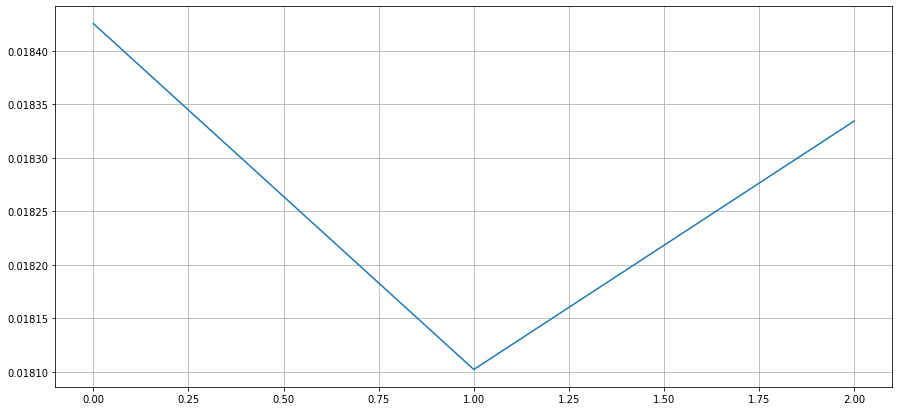

In [105]:
plt.plot([min(x) for x in fold_val_losses], label = "individual model losses")
# plt.axhline(y = min([min(x) for x in fold_val_losses]), linestyle = "--", c = "r")
plt.plot([min(m) for m in ensemble_fold_val_losses], label = "ensemble model fold losses")
plt.grid()

In [ ]:
for l in fold_val_losses:
    plt.plot(l)
    plt.scatter([l.index(min(l))], [min(l)],s = 95, label = str(min(l)))
plt.grid()
plt.legend()

minimas = []
for i in fold_val_losses:
    minimas.append(min(i))

np.array(minimas).mean()
## best yet


In [ ]:
all_models = [Model() for i in range (NFOLDS)]

for i in range (len(all_models)):
    
    name = "./model_" + str(i + 1) + ".pth"
    all_models[i].load_state_dict(torch.load(name))
    all_models[i].to(device)
    print("Loaded: ", name)


In [346]:
all_val_losses = []
for i in range(len(all_models)):
    print(i)
    losses, val_losses = train_one_fold(all_models[i],1 , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = 0, train = False, validate = True)
    all_val_losses.append(np.mean(np.array(val_losses)))
all_val_losses = np.array(all_val_losses)
print("done validating")

0
1
2
3
4
5
6
7
done validating


In [347]:
class model_jury(object):   ## only works for dataloaders for batch size 1 
    def __init__(self, all_models):
        self.all_models = all_models
             
    def predict(self, x, plot = False, sigmoid = False):
        
        with torch.no_grad():
            
            if sigmoid == False:
                preds = [self.all_models[i](x.to(device)).view(-1).cpu().tolist() for i in range(len(self.all_models))]
            else:
                preds = [self.all_models[i](x.to(device)).view(-1).cpu().sigmoid().tolist() for i in range(len(self.all_models))]

        if plot == True:
            for pred in preds:
                plt.plot(pred)
            plt.show()
            
        preds = np.array(preds)
        mean = np.mean(preds, axis = 0)
        return mean.flatten()
jury = model_jury(all_models)

In [348]:
"Using " + str(len(jury.all_models)) + "  models"

'Using 8  models'

In [349]:
test_dataset = TrainDataset(test, target, noise = False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
val_loader_test_jury = DataLoader(dataset= valid_dataset, batch_size=1, shuffle=False)

In [350]:
with torch.no_grad():
    benchmark_losses = []
    criterion = nn.BCEWithLogitsLoss()
    for batch in tqdm(val_loader_test_jury):
        x, y = batch
        pred = jury.predict(x, plot = False, sigmoid = False)
        pred = torch.tensor(pred).view(1,-1)
        benchmark_losses.append(criterion(pred, y))

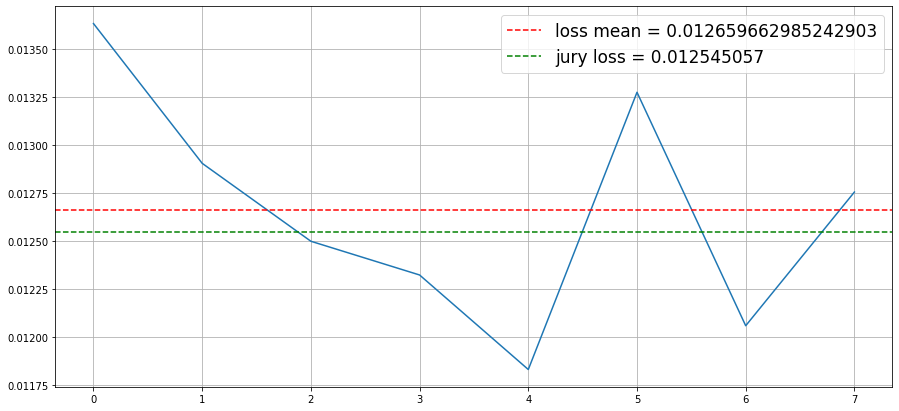

In [351]:
plt.plot(all_val_losses)
plt.axhline(y = all_val_losses.mean(), label = "loss mean = " + str(all_val_losses.mean()), c = "r", linestyle = "--")
plt.axhline(y = np.array(benchmark_losses).mean(), label = "jury loss = " + str(np.array(benchmark_losses).mean()), c = "g", linestyle = "--")
plt.legend(fontsize = 17)
plt.grid()
plt.show()

In [352]:
list_of_preds = []
for batch in tqdm(test_loader):
    x, y = batch
    foo = jury.predict(x, plot = False, sigmoid = True)
    list_of_preds.append(foo)


In [270]:
submission = pd.read_csv('sample_submission.csv')
sub_cp = submission
sub_cp.to_csv('./submission_cp.csv', index=None, header=True)

import csv 
a = list_of_preds  
with open('./submission_cp.csv', "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(a)

final_sub = pd.read_csv('./submission_cp.csv', header = None)

final_sub.columns = submission.columns[1:]
final_sub["sig_id"] = submission["sig_id"]

good_cols = np.roll(final_sub.columns.values, 1)
final_sub = final_sub[good_cols]

In [271]:
targets = [col for col in final_sub.columns]
final_sub.loc[test_features['cp_type']=='ctl_vehicle', targets[1:]] = 0
final_sub.to_csv('submission.csv', index=False)

In [272]:
final_sub

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.000595,0.000856,0.002042,0.013440,0.019780,0.003887,0.001094,0.005382,0.000117,0.010027,0.016236,0.001043,0.000427,0.000590,0.000876,0.000612,0.001695,0.005099,0.008744,0.002214,0.001567,0.003727,0.000353,0.001070,0.000444,0.000368,0.000929,0.000684,0.004956,0.001420,0.000779,0.002858,0.003003,0.000154,0.000154,0.000378,0.003744,0.000371,0.001115,...,0.002173,0.000471,0.003642,0.000381,0.000667,0.001717,0.000258,0.000996,0.000595,0.001327,0.011354,0.007387,0.003647,0.003320,0.000951,0.000802,0.022105,0.002165,0.000452,0.000344,0.000339,0.001554,0.000145,0.000843,0.001006,0.001467,0.000407,0.002120,0.000485,0.000896,0.000620,0.001402,0.002273,0.001185,0.000623,0.000470,0.000840,0.001413,0.007041,0.001030
1,id_001897cda,0.000258,0.000791,0.002039,0.003301,0.002380,0.001579,0.005215,0.006508,0.006297,0.015845,0.012908,0.001900,0.000340,0.012651,0.000536,0.000529,0.000961,0.002431,0.002123,0.003717,0.003324,0.001601,0.000318,0.000761,0.000423,0.001387,0.000829,0.000341,0.001897,0.000860,0.000758,0.001719,0.000736,0.001112,0.000229,0.000214,0.002791,0.003339,0.009280,...,0.001051,0.000914,0.000575,0.000349,0.001306,0.002223,0.001433,0.017750,0.001170,0.002487,0.008545,0.003289,0.000492,0.000911,0.001375,0.003330,0.007222,0.000594,0.021344,0.000356,0.001682,0.003802,0.001993,0.000625,0.000284,0.000795,0.000643,0.002006,0.004418,0.001676,0.000909,0.000787,0.005541,0.000371,0.009803,0.000354,0.009890,0.000721,0.001610,0.003314
2,id_002429b5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_0027